<div style="width: 38.5%;">
    <p><strong>City College of San Francisco</strong><p>
    <hr>
    <p>MATH 108 - Foundations of Data Science</p>
</div>

# Lecture 20: Causality

Associated Textbook Sections: [12.2](https://inferentialthinking.com/chapters/12/2/Causality.html)

<h2>Set Up the Notebook<h2>

In [1]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lecture-20:-Causality" data-toc-modified-id="Lecture-20:-Causality-1">Lecture 20: Causality</a></span><ul class="toc-item"><li><span><a href="#Set-Up-the-Notebook" data-toc-modified-id="Set-Up-the-Notebook-1.1">Set Up the Notebook</a></span></li><li><span><a href="#" data-toc-modified-id="-1.2"></a></span></li><li><span><a href="#Causality" data-toc-modified-id="Causality-1.3">Causality</a></span><ul class="toc-item"><li><span><a href="#Randomized-Controlled-Experiment" data-toc-modified-id="Randomized-Controlled-Experiment-1.3.1">Randomized Controlled Experiment</a></span></li><li><span><a href="#Demo:-Randomized-Control-Experiment" data-toc-modified-id="Demo:-Randomized-Control-Experiment-1.3.2">Demo: Randomized Control Experiment</a></span></li><li><span><a href="#Before-the-Randomization" data-toc-modified-id="Before-the-Randomization-1.3.3">Before the Randomization</a></span></li><li><span><a href="#The-Data" data-toc-modified-id="The-Data-1.3.4">The Data</a></span></li><li><span><a href="#The-Hypotheses" data-toc-modified-id="The-Hypotheses-1.3.5">The Hypotheses</a></span></li><li><span><a href="#Demo:-Testing-the-Hypothesis" data-toc-modified-id="Demo:-Testing-the-Hypothesis-1.3.6">Demo: Testing the Hypothesis</a></span></li><li><span><a href="#Random-Assignment-&amp;-Shuffling" data-toc-modified-id="Random-Assignment-&amp;-Shuffling-1.3.7">Random Assignment &amp; Shuffling</a></span></li></ul></li><li><span><a href="#An-Error-Probability" data-toc-modified-id="An-Error-Probability-1.4">An Error Probability</a></span><ul class="toc-item"><li><span><a href="#Can-the-Conclusion-be-Wrong?" data-toc-modified-id="Can-the-Conclusion-be-Wrong?-1.4.1">Can the Conclusion be Wrong?</a></span></li><li><span><a href="#An-Error-Probability" data-toc-modified-id="An-Error-Probability-1.4.2">An Error Probability</a></span></li><li><span><a href="#P-value-cutoff-vs-P-value" data-toc-modified-id="P-value-cutoff-vs-P-value-1.4.3">P-value cutoff vs P-value</a></span></li></ul></li></ul></li></ul></div>

## Causality

### Randomized Controlled Experiment

* Sample A: control group
* Sample B: treatment group
* If the treatment and control groups are selected at random, then you can make causal conclusions.
* Any difference in outcomes between the two groups could be due to chance or the treatment.


### Demo: Randomized Control Experiment

Load the data in `bta.csv` that is associated with an experiment to assess whether or not Botox and be used to reduce pain.

In [2]:
botox = Table.read_table('bta.csv')
botox.show()

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


Compare the results for the two groups.

In [3]:
botox.pivot('Result', 'Group')

/opt/conda/lib/python3.9/site-packages/datascience/tables.py:920: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array(tuple(values))


Group,0.0,1.0
Control,14,2
Treatment,6,9


In [4]:
botox.group('Group', np.average)

Group,Result average
Control,0.125
Treatment,0.6


### Before the Randomization

* In the population there is one imaginary ticket for each of the 31 participants in the experiment.
* Each participant’s ticket looks like this:

<img src="img/lec20_before_randomization.png" width=70%>

### The Data

16 randomly picked tickets show:

<img src="img/lec20_16_tickets.png" width=50%>

The remaining 15 tickets show:

<img src="img/lec20_15_remaining.png" width=50%>

### The Hypotheses

* Null: In the population, the distribution of all potential control scores is the same as the distribution of all potential treatment scores. (The treatment has no effect.)
* Alternative: In the population, more of the potential treatment scores are 1 (pain improves) than the potential control scores.

### Demo: Testing the Hypothesis

Compute the observed difference in results for the treatment and control groups using the `difference_of_means` function.

In [5]:
def difference_of_means(table, numeric_label, group_label):
    """
    Takes: name of table, column label of numerical variable,
    column label of group-label variable
    
    Returns: Difference of means of the two groups
    """
    
    #table with the two relevant columns
    reduced = table.select(numeric_label, group_label)  
    
    # table containing group means
    means_table = reduced.group(group_label, np.average)
    
    # array of group means
    means = means_table.column(1)
    
    return means.item(1) - means.item(0)

In [6]:
observed_diff = difference_of_means(botox, 'Result', 'Group')
observed_diff

0.475

Use `one_simulated_difference` to determine the chance of observing the above sample data if it were true that Botox had no impact on pain reduction.

In [7]:
def one_simulated_difference(table, numeric_label, group_label):
    """
    Takes: name of table, column label of numerical variable,
    column label of group-label variable
    
    Returns: Difference of means of the two groups after shuffling labels
    """
    
    # array of shuffled labels
    shuffled_labels = table.sample(
        with_replacement = False).column(group_label)
    
    # table of numerical variable and shuffled labels
    shuffled_table = table.select(numeric_label).with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(
        shuffled_table, numeric_label, 'Shuffled Label')   

In [8]:
one_simulated_difference(botox, 'Result', 'Group')

0.08750000000000002

In [9]:
simulated_diffs = make_array()

for i in np.arange(10000):
    sim_diff = one_simulated_difference(botox, 'Result', 'Group')
    simulated_diffs = np.append(simulated_diffs, sim_diff)

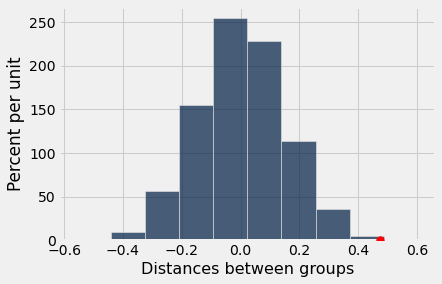

In [10]:
col_name = 'Distances between groups'
Table().with_column(col_name, simulated_diffs).hist(col_name)
plots.scatter(observed_diff, 0, color="red", s=60, zorder=3);

In [11]:
p_value = sum(simulated_diffs >= observed_diff)/len(simulated_diffs)
p_value

0.006

### Random Assignment & Shuffling

<img src="img/lec20_random_assignment_and_shuffling.png" width=80%>

## An Error Probability

### Can the Conclusion be Wrong?

Yes.

|  | Null is True | Alternative is True
| --- | ----------- | |
| Test favors the Null | ✅ | ❌ |
| Test favors the Alternative | ❌ | ✅ |

### An Error Probability

* The cutoff for the P-value is an error probability.
* If your cutoff is 5% and the null hypothesis happens to be true, then there is about a 5% chance that your test will reject the null hypothesis.

### P-value cutoff vs P-value

* P-value cutoff
    * Does not depend on observed data or simulation
    * Decide on it before seeing the results
    * Conventional values at 5% and 1%
    * Probability of hypothesis testing making an error
* P-value
    * Depends on the observed data and simulation
    * Probability under the null hypothesis that the test statistic is the observed value or further towards the alternative


<footer>
    <hr>
    <p>Adopted from UC Berkeley DATA 8 course materials.</p>
    <p>This content is offered under a <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/">CC Attribution Non-Commercial Share Alike</a> license.</p>
</footer>